ve been dealing with autocorrelated data a lot lately. In finance, certain time series such as housing prices or private equity returns are notoriously autocorrelated. Properly accounting for this autocorrelation is critical to building a robust model.

First, what is autocorrelation? Autocorrelation is when past observations have an impact on current ones. For example, if you could use Apple’s returns last week to reliably predict its returns this week, then you can say that Apple’s stock price returns are autocorrelated. In math terms:

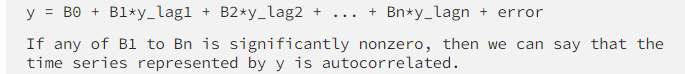

Why Do We Care About Autocorrelation?
Two reasons come to my mind:

Many things are autocorrelated. So when we attempt to study the world by building simulations (e.g. Monte Carlo simulations of the economy), we need to take that autocorrelation into account. Otherwise our model would produce faulty results (see reason 2 for why).
Autocorrelation causes volatility to be understated, especially when compounded. The compounded product, that is (1+r1)*(1+r2)… of an autocorrelated random variable can have a much wider distribution of outcomes than that of a random variable with no autocorrelation.

Let’s use some actual data to study this. I downloaded some CPI data from FRED (the data repository of the Federal Reserve Bank of St. Louis). It looks like this:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

%matplotlib inline

In [14]:
df=pd.read_csv("CPIAUCSL.csv" )

In [15]:
df

,DATE,CPIAUCSL
0,1947-01-01,21.480
1,1947-02-01,21.620
2,1947-03-01,22.000
3,1947-04-01,22.000
4,1947-05-01,21.950
...,...,...
908,2022-09-01,296.539
909,2022-10-01,297.987
910,2022-11-01,298.598
911,2022-12-01,298.990


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      913 non-null    object 
 1   CPIAUCSL  913 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.4+ KB


In [19]:
df['DATE'] = pd.to_datetime(df.DATE)


In [22]:
df=df.set_index("DATE")

<AxesSubplot:xlabel='DATE'>

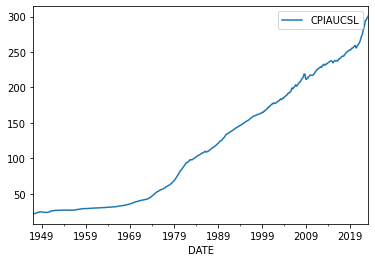

In [23]:
df.plot()

In [25]:
#The following line calculates the monthly rate of change
df_chg = (df/df.shift(1)-1).dropna()

In [26]:
df_chg

,CPIAUCSL
DATE,
1947-02-01,0.006518
1947-03-01,0.017576
1947-04-01,0.000000
1947-05-01,-0.002273
1947-06-01,0.005923
...,...
2022-09-01,0.004128
2022-10-01,0.004883
2022-11-01,0.002050


<AxesSubplot:xlabel='DATE'>

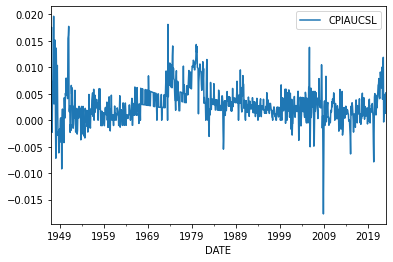

In [27]:
df_chg.plot()

We can do a check for autocorrelation by looking at the correlation of the monthly change in CPI against its lagged values. We can use the shift method to create the lags.

In [33]:
df_chg.rename({'CPIAUCSL': 'unlagged'}, axis=1, inplace=True)
lags = 10
for i in range(lags):
    if i > 0:
        df_chg['lag_'+str(i)] = df_chg['unlagged'].shift(i)

Plotting the correlations between the unlagged values of CPI change against its various lags, we see that there’s significant autocorrelation:

In [30]:
df_chg

,unlagged,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
DATE,,,,,,,,,,
1947-02-01,0.006518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,0.017576,0.006518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,0.000000,0.017576,0.006518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-05-01,-0.002273,0.000000,0.017576,0.006518,NaN,NaN,NaN,NaN,NaN,NaN
1947-06-01,0.005923,-0.002273,0.000000,0.017576,0.006518,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-01,0.004128,0.002349,-0.000339,0.011879,0.009206,0.003962,0.010056,0.007116,0.006095,0.007807
2022-10-01,0.004883,0.004128,0.002349,-0.000339,0.011879,0.009206,0.003962,0.010056,0.007116,0.006095
2022-11-01,0.002050,0.004883,0.004128,0.002349,-0.000339,0.011879,0.009206,0.003962,0.010056,0.007116


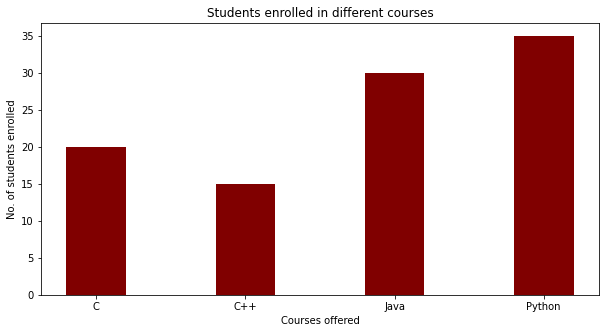

In [36]:
data = {'C':20, 'C++':15, 'Java':30,
        'Python':35}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

In [47]:
courses

['C', 'C++', 'Java', 'Python']

In [63]:
values

[20, 15, 30, 35]

In [43]:
df_chg.values.T.shape

(10, 912)

In [57]:
import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(df_chg.unlagged,nlags= 10)

array([1.        , 0.57658302, 0.41107637, 0.38167121, 0.36172723,
       0.35340664, 0.34807998, 0.35503835, 0.34155866, 0.367072  ,
       0.38524347])

In [60]:
df_chg.columns

Index(['unlagged', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9'],
      dtype='object')

In [67]:
list_=list(sm.tsa.acf(df_chg.unlagged,nlags= 9))
list_

[1.0,
 0.5765830233251932,
 0.41107637402253144,
 0.3816712132912243,
 0.3617272252280481,
 0.35340664133875704,
 0.34807998447288385,
 0.35503834604171236,
 0.3415586636025603,
 0.3670720014072967]

<BarContainer object of 10 artists>

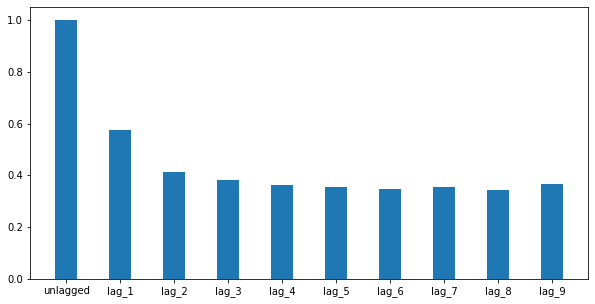

In [72]:
fig = plt.figure(figsize = (10, 5))
# Set the figure size - handy for larger output
#from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'
# creating the bar plot
plt.bar(df_chg.columns,list_ ,
        width = 0.4)

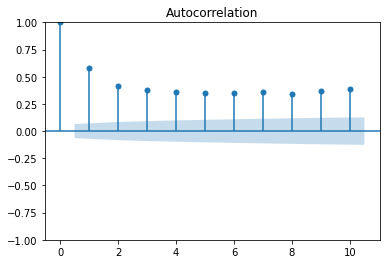

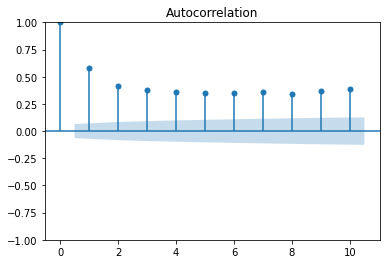

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_chg.unlagged,lags= 10)

https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/